In [1]:
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
import numpy as np
import pandas as pd

import h5py, json
from osgeo import ogr

from pyproj import Proj
proj_stere = Proj('epsg:3031')

%matplotlib widget

/var/folders/wj/bw8g86p56yq5f9gwsp5vq4640000gq/T/ipykernel_9290/2631867981.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
### Load the bed pick dataframe ###

df = pd.read_csv('../../proc/Picked_Bed_Power.csv')

In [3]:
### Filter the dataset to Whillans Ice Plain only ###

# All flight days
fdays = np.sort(df['Flight Day'].unique())

# Kamb flight days
kamb_days = fdays[[1,3,4,7]]  #4
# Whillans flight days
whillans_days = np.delete(fdays,[1,3,4,7])

# Separate dataframes
kamb_df = df[df['Flight Day'].isin(kamb_days)]
df = df[df['Flight Day'].isin(whillans_days)]
# Add in a single frame from a kamb day where part of the flight was over SLW
df = pd.concat([df, kamb_df[(kamb_df['Flight Day']==20131227) & (kamb_df['Frame'] == 12)]])

# Subset Whillans dataframe by y coordinate
df = df[df['Y'] > -1e6]
df = df[df['Y'] < -.48e6]

# Remove traces with large aircraft roll
df = df[abs(df['Roll']) < 0.1]

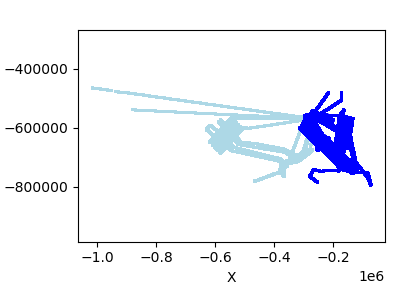

In [4]:
# Plot to check that the days are correct
plt.figure(figsize=(4,3))
ax = plt.subplot(111)
kamb_df.plot.scatter(ax=ax,x='X',y='Y',c='lightblue',s=1)
df.plot.scatter(ax=ax,x='X',y='Y',c='b',s=1)
ax.axis('equal')
plt.tight_layout()

In [5]:
### A function to level the power at crossover points ###

def crossover_leveling(df,days,days_to_add,crossover_dist=100,print_num=5000,verbose=False):
    
    # Separate into two dataframes, 1st the 'true' power and 2nd to adjust
    idxs1 = df['Flight Day'].isin(days)
    idxs2 = df['Flight Day'].isin(days_to_add)
    df1 = df.loc[idxs1]
    df2 = df.loc[idxs2]
    
    # Empty array for power differences
    dP = np.array([])
    
    # Loop through every trace in the 2nd dataframe
    for i,idx in enumerate(df2.index):
        if i%print_num==0 and verbose:
            print(round(i/len(df2),3)*100,'% finished...')
            print('Total crossover traces added:',len(dP))
        # Get the distance from the selected trace to every trace in df1
        dist = np.sqrt((df2.loc[idx,'X']-df1['X'])**2.+(df2.loc[idx,'Y']-df1['Y'])**2.)
        # Add the power difference for 
        dP = np.append(dP,df1['Power'][dist<crossover_dist] - df2.loc[idx,'Power'])

    # Adjust the power for the added days
    df.loc[idxs2,'Power'] = df.loc[idxs2,'Power'] + np.nanmean(dP)

    if verbose:
        print("Power adjusted by:",np.nanmean(dP),' for days:',days_to_add)
        
    return df, dP

Crossover Leveling Adjustment # 1
Control Days: [20131219]
Adjusted Days: 20131223
0.0 % finished...
Total crossover traces added: 0
11.200000000000001 % finished...
Total crossover traces added: 2532
22.3 % finished...
Total crossover traces added: 3507
33.5 % finished...
Total crossover traces added: 4777
44.6 % finished...
Total crossover traces added: 6048
55.800000000000004 % finished...
Total crossover traces added: 7330
67.0 % finished...
Total crossover traces added: 9872
78.10000000000001 % finished...
Total crossover traces added: 11133
89.3 % finished...
Total crossover traces added: 11133
Power adjusted by: -1.5742885142651473  for days: [20131223]


Crossover Leveling Adjustment # 2
Control Days: [20131219, 20131223]
Adjusted Days: 20140108
0.0 % finished...
Total crossover traces added: 0
9.5 % finished...
Total crossover traces added: 3086
19.1 % finished...
Total crossover traces added: 3086
28.599999999999998 % finished...
Total crossover traces added: 3086
38.1 % fini

Text(0, 0.5, 'Number of Traces')

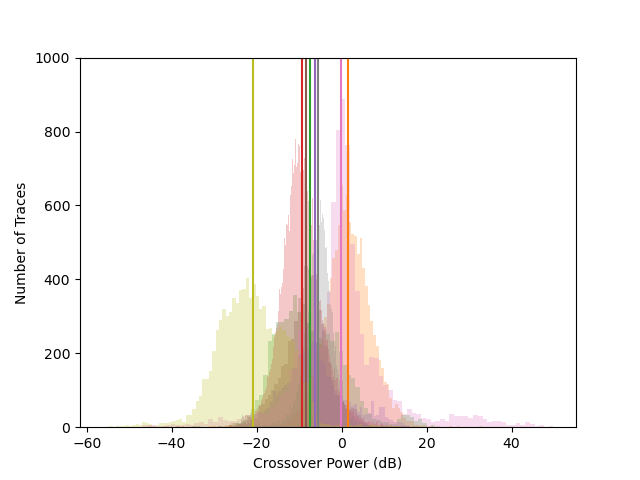

In [6]:
### Do the crossover power adjustment for each day ###

# An copy of the dataframe to adjust
df_adj = df.copy()

# Add days in a specific order to maximize crossover points
day_order = [20131219, 20131223, 20140108, 20140104, 20140109, 20131231, 20140111, 20131227, 20140102]

# Initialize the figures and colors to plot for each day
plt.figure()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i in range(1,9):
    # Do the adjustment for each day, using the function from the previous cell
    print("Crossover Leveling Adjustment #",i)
    print("Control Days:",day_order[:i])
    print("Adjusted Days:",day_order[i])
    df_adj, dP = crossover_leveling(df_adj,day_order[:i],[day_order[i]],crossover_dist=100,print_num=10000,verbose=True)
    print("\n")
    
    # Plot a histogram of power difference at crossover points
    plt.hist(-dP,bins=len(dP)//100,color=colors[i],alpha=0.25)
    plt.axvline(-np.nanmean(dP),color=colors[i])
    
plt.ylim(0,1000)
plt.xlabel('Crossover Power (dB)')
plt.ylabel('Number of Traces')

0.0 % finished...
Total crossover traces added: 0
21.0 % finished...
Total crossover traces added: 11227
42.0 % finished...
Total crossover traces added: 17946
63.1 % finished...
Total crossover traces added: 19186
84.1 % finished...
Total crossover traces added: 20979
Power adjusted by: -0.16258387385618076  for days: [20140109, 20131231, 20140111, 20131227, 20140102]


Text(0, 0.5, 'Number of Traces')

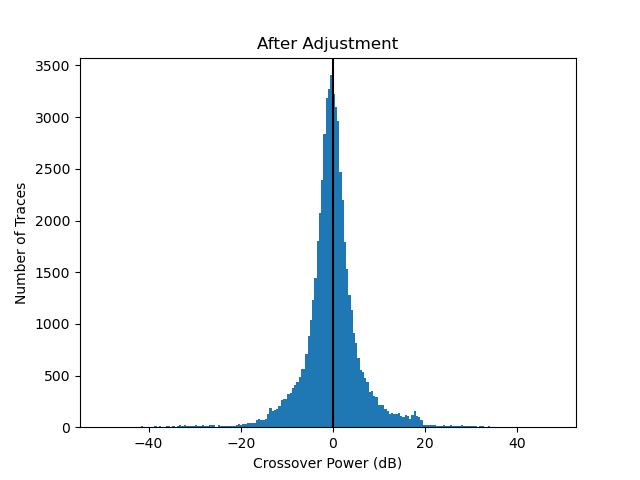

In [7]:
### Recalculate the crossover power for the adjusted dataset, on all days ###
### Make sure Surface Time is centered on 0 ###

df_hold, dP = crossover_leveling(df_adj,day_order[:4],day_order[4:],print_num=50000,verbose=True)

plt.figure()
plt.hist(dP,bins=200)
plt.axvline(0,color='k')
plt.title('After Adjustment')
plt.xlabel('Crossover Power (dB)')
plt.ylabel('Number of Traces')

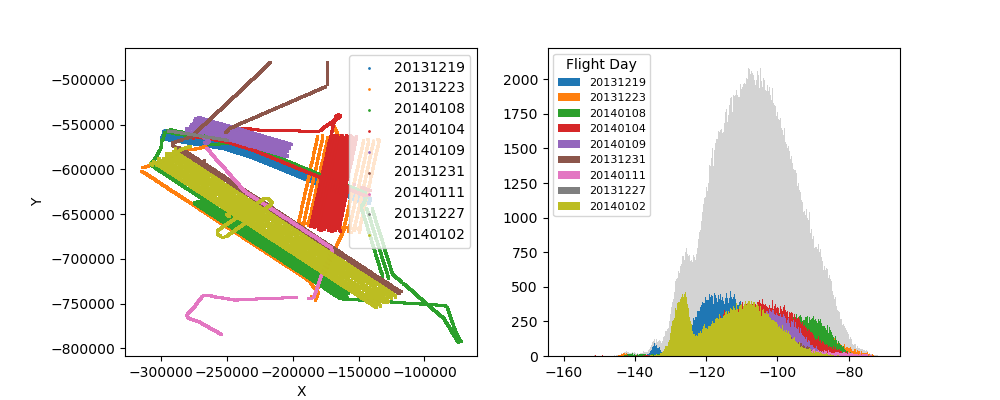

In [8]:
plt.figure(figsize=(10,4))

ax1 = plt.subplot(121)
for i in range(9):
    df[df['Flight Day']==day_order[i]].plot.scatter(ax=ax1,x='X',y='Y',c=colors[i],s=1,label=day_order[i])

ax2 = plt.subplot(122)
bins = np.arange(-160,-70,0.1)
plt.hist(df_adj['Power'],bins=bins,color='lightgrey');
for i,day in enumerate(day_order):
    plt.hist(df_adj[df_adj['Flight Day']==day]['Power'],bins=bins,color=colors[i],label=day)
plt.legend(title='Flight Day',fontsize=8)

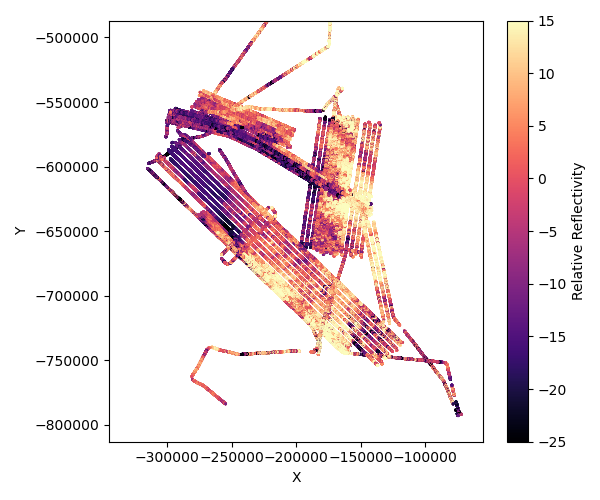

In [9]:
### Calculate a relative reflectivity ###

c = 3e8
epsr_ice = 3.15
c_ice = c/np.sqrt(epsr_ice)

df_adj['H'] = c_ice/2. * (df_adj['Bed Time']-df_adj['Surface Time'])
df_adj['h'] = c/2. * df_adj['Surface Time']
G = 20*np.log10(2.*(df_adj['h'] + df_adj['H']/np.sqrt(epsr_ice)))

# Attenuation
N = 10 # one-way rate (dB/km)
L = 2.*N * df_adj['H']/1000.

# Reflectivity
df_adj['Relative Reflectivity'] = df_adj['Power'] + G + L
# Move the mean to 0
df_adj['Relative Reflectivity'] -= df_adj['Relative Reflectivity'].mean()


plt.figure(figsize=(6,5))

ax1 = plt.subplot(111)
df_adj.plot.scatter(ax=ax1,x='X',y='Y',c='Relative Reflectivity',cmap='magma',s=1,vmin=-25,vmax=15)
ax1.axis('equal')
plt.xlim(-300000,-100000)
plt.ylim(-800000,-500000)
plt.tight_layout()

In [10]:
### Import InSAR grounding line and create a mask for traces grounded/floating ###

file = ogr.Open("/Users/bhills/Drive/Research/Maps/antarctica/Outlines/5000001062176/128409163/GroundingLine_Antarctica_v02.shp")
shape = file.GetLayer(0)
feature = shape.GetFeature(0) #first feature of the shapefile
gls = json.loads(feature.ExportToJson())['geometry']['coordinates']
gl_coords = np.empty((0,2))
for gl in gls:
    gl_coords = np.append(gl_coords,gl[0],axis=0)
    
start = 35000
end = 38000
gl_crop = gl_coords[start:end]
gl_crop = np.append(gl_crop,np.array([[-1000000,0],[1000000,0],gl_crop[0]]),axis=0)

gl_Path = mplPath.Path(np.transpose([gl_crop[:,0],gl_crop[:,1]]))
df_adj['Grounded'] = gl_Path.contains_points(df_adj[['X','Y']]).astype(bool)

In [11]:
### Import lake outlines and create a mask for traces lake/not-lake ###

# Subglacial lake outlines (Siegfried & Fricker, 2018)
lakes = h5py.File('../../data/outlines/SiegfriedFricker2018-outlines.h5', 'r')
wh_lake_keys = ['EngelhardtSubglacialLake', 'WhillansSubglacialLake', 'Whillans_6', 'Whillans_7', 'Whillans_8','Lake78','Lake10']

df_adj['Lake'] = np.zeros_like(df_adj['X']).astype(bool)

for key in wh_lake_keys:
    lake_x = np.squeeze(lakes[key]['x'][:])
    lake_y = np.squeeze(lakes[key]['y'][:])
    lake_Path = mplPath.Path(np.transpose([lake_x,lake_y]))
    df_adj[key] = lake_Path.contains_points(df_adj[['X','Y']]).astype(bool)
    df_adj['Lake'] = np.logical_or(df_adj['Lake'],df_adj[key])

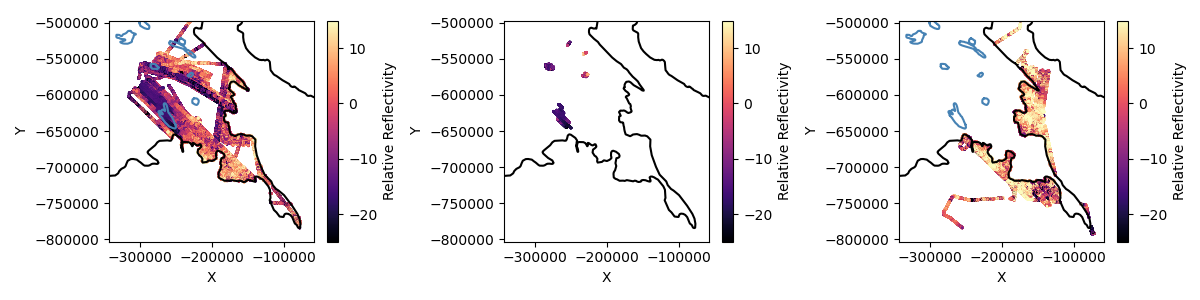

In [12]:
plt.figure(figsize=(12,3))

ax1 = plt.subplot(131)
df_adj[df_adj['Grounded']==True].plot.scatter(ax=ax1,x='X',y='Y',c='Relative Reflectivity',cmap='magma',s=1,vmin=-25,vmax=15)
plt.plot(gl_crop[:,0],gl_crop[:,1],'k-')
ax1.axis('equal')
plt.xlim(-300000,-100000)
plt.ylim(-800000,-500000)

ax2 = plt.subplot(132)
df_adj[df_adj['Lake']==True].plot.scatter(ax=ax2,x='X',y='Y',c='Relative Reflectivity',cmap='magma',s=1,vmin=-25,vmax=15)
plt.plot(gl_crop[:,0],gl_crop[:,1],'k-')
ax2.axis('equal')
plt.xlim(-300000,-100000)
plt.ylim(-800000,-500000)

ax3 = plt.subplot(133)
df_adj[df_adj['Grounded']==False].plot.scatter(ax=ax3,x='X',y='Y',c='Relative Reflectivity',cmap='magma',s=1,vmin=-25,vmax=15)
plt.plot(gl_crop[:,0],gl_crop[:,1],'k-')
ax3.axis('equal')
plt.xlim(-300000,-100000)
plt.ylim(-800000,-500000)

for key in lakes.keys():
    lake_x = np.squeeze(lakes[key]['x'][:])
    lake_y = np.squeeze(lakes[key]['y'][:])
    for ax in [ax1,ax3]:
        ax.plot(lake_x,lake_y,c='steelblue')
        
plt.tight_layout()

In [14]:
df_adj.to_csv('../../proc/Processed_Reflectivity.csv')